# Transfer Learning (EfficientNet)

Previously, [we built a robust](./02-cnn-tuned.ipynb), VGG-inspired CNN from scratch and, through careful tuning and data augmentation, achieved a respectable 86% accuracy. 

We have already applied a **transfer learning** for a different class of task [before](../sentiment/05-roberta.ipynb), but we are going to use this approach more and more - due to how *awesome* it is. This time we are going to use an **EfficientNet** model, a modern and highly effective architecture known for its excellent performance and computational efficiency. Let's see if we can push our accuracy even higher by leveraging its power.

## Data Preparation

In [1]:
from datasets import load_dataset
import numpy as np

train, test = load_dataset('uoft-cs/cifar10', split=['train', 'test'])
class_names = train.features['label'].names

x_train = np.array(train['img'])
y_train = np.array(train['label'])
x_test = np.array(test['img'])
y_test = np.array(test['label'])

An important step in transfer learning is to use the same preprocessing that the original model was trained with. Instead of normalizing our data by simply dividing by 255.0, we must use the `preprocess_input` function of a specific model, which ensures our images match the original training conditions.

In [2]:
from tensorflow.keras.applications.efficientnet import preprocess_input
x_train = preprocess_input(np.array([np.array(x) for x in x_train]))
x_test = preprocess_input(np.array([np.array(x) for x in x_test]))

## Data Augmentation

In [3]:
from tensorflow.keras import layers, Sequential
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomCrop(32, 32),
])

## Building and Training the Model

Generally, our general architecture will remain the same, but instead of building our feature detection from scratch, we might borrow the visual cortex of **EfficientNet**. 

It already knows how to recognize a rich hierarchy of features — from simple edges and textures to complex patterns and object parts like fur, wheels, or leaves. We set `include_top=False` to discard the original classifier, allowing us to attach our own custom head tailored for the 10 CIFAR-10 classes.

We might also rework our classification head a bit too - by giving it more dense neurons and swapping the simple flatten layer to global average pooling,allowing it to capture more context and summarize our features more effectively.

In [4]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers, Sequential

original_shape = x_train.shape[1:]
upscaled_shape = (128, 128, 3) # x3
set_random_seed(0)

efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=upscaled_shape)
feature_learning = Sequential(name='feature_learning', layers=[
    layers.Input(shape=original_shape),
    layers.Resizing(upscaled_shape[0], upscaled_shape[1]),
    efficientnet,
])

classification = Sequential(name='classification', layers=[
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.75),
    layers.Dense(len(class_names), activation='softmax'),
])

model = Sequential([
    feature_learning,
    classification,
])

display(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_learning (Sequential)   │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Sequential)     │ (None, 10)             │     1,331,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,380,781 (20.53 MB)

 Trainable params: 5,334,150 (20.35 MB)

 Non-trainable params: 46,631 (182.16 KB)

None

You may notice we haven't used the data augmentation layer yet - that's done by purpose, and soon you are going to understand why. We should also completely freeze the pre-trained model, and train exclusively the classification head - the default optimizer might destroy its weights.

In [5]:
for layer in efficientnet.layers:
    layer.trainable = False

We might train our model now.

In [6]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 150ms/step - accuracy: 0.7660 - loss: 0.8195 - val_accuracy: 0.8863 - val_loss: 0.3461
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.8596 - loss: 0.4229 - val_accuracy: 0.8905 - val_loss: 0.3209
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.8779 - loss: 0.3633 - val_accuracy: 0.8924 - val_loss: 0.3121
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - accuracy: 0.8826 - loss: 0.3397 - val_accuracy: 0.8944 - val_loss: 0.3106
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 140ms/step - accuracy: 0.8917 - loss: 0.3138 - val_accuracy: 0.8968 - val_loss: 0.3052


Looks pretty good, isn't it?

But we are not done yet. We might push our model even further by **fine-tuning** its feature learning part as well! To do this, let's unfreeze a few layers on the top of its underlying sub-model. The exact number may vary, but we may start with the entire convolutional block.

In [7]:
for layer in efficientnet.layers[-16:]:
    layer.trainable = True
display(efficientnet.summary(show_trainable=True))

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 128,     │         0 │ input_layer[0… │   -   │
│ (Rescaling)       │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 128,     │         7 │ rescaling[0][… │   N   │
│ (Normalization)   │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling_1       │ (None, 128,     │         0 │ normalization… │   -   │
│ (Rescaling)       │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv_pad     │ (None, 129,     │         0 │ rescaling_1[0… │   -   │
│ (ZeroPadding2D)   │ 129, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 64, 64,  │       864 │ stem_conv_pad… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 64, 64,  │       128 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 64, 64,  │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_dwconv    │ (None, 64, 64,  │       288 │ stem_activati… │   N   │
│ (DepthwiseConv2D) │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_bn        │ (None, 64, 64,  │       128 │ block1a_dwcon… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_activati… │ (None, 64, 64,  │         0 │ block1a_bn[0]… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_squee… │ (None, 32)      │         0 │ block1a_activ… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_resha… │ (None, 1, 1,    │         0 │ block1a_se_sq… │   -   │
│ (Reshape)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_reduce │ (None, 1, 1, 8) │       264 │ block1a_se_re… │   N   │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_expand │ (None, 1, 1,    │       288 │ block1a_se_re… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_se_excite │ (None, 64, 64,  │         0 │ block1a_activ… │   -   │
│ (Multiply)        │ 32)             │           │ block1a_se_ex… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 64, 64,  │       512 │ block1a_se_ex… │   N 

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 1,129,392 (4.31 MB)

 Non-trainable params: 2,920,179 (11.14 MB)

None

Next, we need an optimizer with a **very low** learning rate. Adam with decoupled weight decay would do just great.

In [8]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.0002)

Finally, we may add the augmentation layer. We deferred adding it in the previous stage because we wanted the classifier to learn from the clean, pre-processed features. Using it now is crucial to prevent our final model from overfitting to our specific dataset.

In [9]:
feature_learning.layers.insert(1, data_augmentation)

We may train our model now.

In [10]:
with device('/GPU'):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 165ms/step - accuracy: 0.8715 - loss: 0.3847 - val_accuracy: 0.9094 - val_loss: 0.2710
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.9241 - loss: 0.2182 - val_accuracy: 0.9167 - val_loss: 0.2522
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 175ms/step - accuracy: 0.9445 - loss: 0.1595 - val_accuracy: 0.9191 - val_loss: 0.2535
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.9602 - loss: 0.1195 - val_accuracy: 0.9200 - val_loss: 0.2552
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 171ms/step - accuracy: 0.9689 - loss: 0.0913 - val_accuracy: 0.9221 - val_loss: 0.2603


## Result

In [11]:
from sklearn.metrics import classification_report
with device('/GPU'):
    y_pred_values = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_values, axis=1)
    print(classification_report(y_test, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.92      0.95      0.93      1000
  automobile       0.94      0.97      0.95      1000
        bird       0.93      0.90      0.91      1000
         cat       0.88      0.81      0.84      1000
        deer       0.88      0.93      0.91      1000
         dog       0.85      0.91      0.88      1000
        frog       0.95      0.94      0.94      1000
       horse       0.96      0.92      0.94      1000
        ship       0.96      0.94      0.95      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



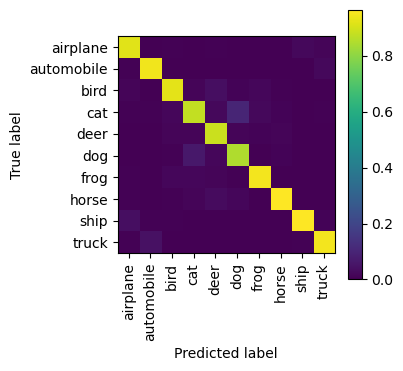

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_labels, 
    display_labels=class_names, 
    normalize='pred',
    xticks_rotation='vertical',
    include_values=False, 
    ax=ax
)

## Conclusion

By leveraging a pre-trained EfficientNet model, we dramatically improved our performance, reaching an impressive **92%** accuracy. This demonstrates the power of transfer learning - by standing on the shoulders of models trained on vast datasets, we can achieve excellent results with relatively little training time and data. 